In [4]:
#!pip install h5py

## <span style="color:#08088A">  Settings  </span>

### <span style="color:#08088A">  Needed libraries  </span>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import imdb
import numpy                  as np
import pandas                 as pd
import scipy                  as sp
import sklearn.neighbors      as knn
import matplotlib
import matplotlib.pyplot      as plt
import seaborn
import requests
import urllib
import joblib
import requests
import json
import os
import random
import seaborn as sns
import PIL
import h5py
import math
import os
#import statsmodels.api as sm
from ast                                  import literal_eval
from matplotlib                           import rcParams
from sklearn                              import discriminant_analysis
from sklearn.decomposition                import PCA
from sklearn                              import preprocessing
from sklearn.linear_model                 import LogisticRegression as LogReg
from sklearn.discriminant_analysis        import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis        import QuadraticDiscriminantAnalysis as QDA
from sklearn.cross_validation             import train_test_split
from scipy.stats                          import mode
from sklearn                              import linear_model
from IPython.core.interactiveshell        import InteractiveShell
from time                                 import sleep
from collections                          import Counter
from itertools                            import combinations, permutations
from urlparse                             import urljoin

In [3]:
# deep learning packages

from keras.applications.vgg19             import VGG19
from keras.preprocessing                  import image
from keras.applications.vgg19             import preprocess_input
from keras.models                         import Model
from keras.callbacks                      import EarlyStopping
from keras.callbacks                      import LearningRateScheduler
from keras.preprocessing.image            import ImageDataGenerator
from keras.models                         import Sequential
from keras.layers                         import Dense
from keras.layers                         import Dropout
from keras.layers                         import Flatten
from keras.layers                         import Activation
from keras.constraints                    import maxnorm
from keras.optimizers                     import SGD
from keras.layers.convolutional           import Conv2D
from keras.layers.convolutional           import MaxPooling2D
from keras.utils                          import np_utils
from keras                                import backend as K
from keras.callbacks                      import EarlyStopping
from keras                                import initializers
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [4]:
!pwd

/home/ubuntu/my_data_cs109b


In [5]:
from IPython.display import display
from PIL import Image

In [6]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [7]:
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = (20, 10)
rcParams['axes.facecolor'] = "w"
rcParams['grid.color'] = "gray"
rcParams['grid.linewidth'] = 0.5

## <span style="color:#08088A">  Helper functions  </span>

In [11]:
def extract_first_genre(x):
    try:
        return [genre['name'] for genre in literal_eval(x)][0]
    except Exception:
        return 0


In [12]:
def get_np_repr(img_path):
    
    
    
    try:
        img = image.load_img(img_path, target_size=(224, 224))
    except IOError:
        return 0
    x = image.img_to_array(img) # this is a Numpy array with shape (3, 224, 224)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #x = x.reshape( (1,) + x.shape )  # this is a Numpy array with shape (1, 3, 224, 224)
    
    return x

def image_exists(img_path):
    try:
        with open(img_path):
            pass
    except IOError:
        return 0
    return 1

In [14]:
def step_decay(epoch):
#     lrate = 0.01
#     if epoch > 10:
#         lrate = 0.1 / (2. ** epoch)
#     return lrate

    if epoch%2==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)


In [13]:
# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(labels_dict.values())
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight


# attribution: "https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras/13496"

## <span style="color:#08088A">  Stage 1: Ask A Question  </span>

For this milestone you will (finally) use deep learning to predict movie genres. You will train one small network from scratch on the posters only, and compare this one to a pre-trained network that you finetune. [Here](https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras) is a description of how to use pretrained models in Keras.

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

**Note:** Be mindful of the longer training times for deep models. Not only for training time, but also for the parameter tuning efforts. You need time to develop a feel for the different parameters and which settings work, which normalization you want to use, which model architecture you choose, etc. 

It is great that we have GPU's via AWS to speed up the actual computation time, but you need to be mindful of your AWS credits. The GPU instances are not cheap and can accumulate costs rather quickly. Think about your model first and do some quick dry runs with a larger learning rate or large batch size on your local machine. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

## <span style="color:#08088A"> Stage 2: Data processing</span>

###  <span style="color:#08088A">  Loading the imdb and tmdb merge data:  </span> 

In [ ]:
merged_mdb_final = pd.read_csv('merged_mdb_final.txt')
merged_mdb_final = merged_mdb_final.drop('Unnamed: 0', axis=1)

###  <span style="color:#08088A">  Poster data:  </span> 

In [ ]:
base_path = 'https://image.tmdb.org/t/p/{size}/'
local_poster_folder = os.path.expanduser('/home/ubuntu/my_data_cs109b/poster_folder')

if not os.path.exists(local_poster_folder):
   os.mkdir(local_poster_folder)

merged_mdb_final['poster_url'] = merged_mdb_final.poster_path.map(lambda path: urljoin(base_path.format(size = 'w500'), path.replace('/', '')))
##add absolute paths for images
merged_mdb_final['local_poster_path'] = merged_mdb_final.poster_path.map(lambda path: os.path.join(local_poster_folder, path.replace('/', '')))


###  <span style="color:#08088A">  Clean data:  </span> 

- We have poster image size of 'w500' i.e. (500 by 750). We will resize them to 224 by 224.

In [ ]:
merged_mdb_final['img_repr'] = merged_mdb_final.local_poster_path.map(lambda x: get_np_repr(x))

In [ ]:
merged_mdb_final['image_exists'] = merged_mdb_final.local_poster_path.map(lambda x: image_exists(x))

In [ ]:
merged_mdb_final.shape

In [ ]:
merged_mdb_final['img_repr'].shape

In [ ]:
sum(merged_mdb_final['image_exists'])

In [ ]:
merged_mdb_final['genres'].unique()

In [ ]:
merged_mdb_final['final_genre'] = merged_mdb_final['genres'].map(lambda x: extract_first_genre(x))

In [ ]:
Counter(merged_mdb_final['final_genre'])

Removing movies with less than 50 counts

In [ ]:
filtered_merged_mdb_final = merged_mdb_final[~merged_mdb_final.final_genre.isin((0,'War', 'Western', 
                                                                                'TV Movie', 'Foreign',
                                                                               'History', 'Music'))].copy()

In [ ]:
Counter(filtered_merged_mdb_final['final_genre'])

In [ ]:
deepLearning_mdb_final = filtered_merged_mdb_final[['final_genre','img_repr']].copy()

In [ ]:
#deepLearning_mdb_final.to_csv('deepLearning_mdb_final.txt')

In [ ]:
#deepLearning_mdb_final = pd.read_csv('deepLearning_mdb_final.txt')

In [ ]:
deepLearning_mdb_final.head(2)

In [ ]:
deepLearning_mdb_final['img_repr'].shape

In [ ]:

le = preprocessing.LabelEncoder()
le.fit(np.unique([deepLearning_mdb_final.final_genre]))
train, test = train_test_split(deepLearning_mdb_final, test_size=0.30, random_state=123)
img_rows, img_cols = 224, 224
# reshapping 
length = len(train.img_repr)
X_train = np.hstack(([x] for x in list(train.img_repr))).reshape((length, 3, img_rows, img_cols))
y_train = le.transform(train.final_genre).reshape((length, 1))

length2 = len(test.img_repr)
X_test = np.hstack(([x] for x in list(test.img_repr))).reshape((length2, 3, img_rows, img_cols))
y_test = le.transform(test.final_genre).reshape((length2, 1))

In [ ]:
X_train[0:5].shape
y_train[0:5].shape

In [ ]:
len(y_test)

In [ ]:
#X_train[1].astype('float32')

In [ ]:
# normalize inputs from 0-255 to 0.0-1.0

X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_uni_classes = y_test.shape[1]

In [ ]:
len(y_test)

In [ ]:
num_uni_classes

In [ ]:
#saving the files

# joblib.dump(X_train, 'X_train.pkl')
# joblib.dump(X_test, 'X_test.pkl')
# joblib.dump(y_train, 'y_train.pkl')
# joblib.dump(y_test, 'y_test.pkl')


In [8]:
#Loading the files
X_train  = joblib.load('X_train.pkl')
X_test  = joblib.load('X_test.pkl')
y_train  = joblib.load('y_train.pkl')
y_test  = joblib.load('y_test.pkl')

X_train.shape

(2975, 3, 224, 224)

We will go over the following options:

- training a small network from scratch (as a baseline)
- using the baseline model with more data using a data augmentation technic
- fine-tuning the top layers of a pre-trained network


## <span style="color:#08088A"> Stage 3: Deep Learning</span>

### <span style="color:#08088A"> Deep Learning - Network explanation</span> 

Our baseline network structure can be summarized as follows: 


   ==> __First Layer__ 
    
- Convolutional input layer, 32 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
- Max Pool layer with size 2×2.

 ==> __Second Layer__ 
    
- Convolutional layer, 32 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
- Max Pool layer with size 2×2.

 ==> __Thrid Layer__ 
    
- Convolutional layer, 64 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
- Max Pool layer with size 2×2.

==> __Fourth Layer__ 
    
- Convolutional layer, 64 feature maps with a size of 3×3, a rectifier activation function and a weight constraint of max norm set to 3.
- Max Pool layer with size 2×2.


 ==> __Convolutional layer__ 
    
- Flatten layer.
- Fully connected layer with 64 units and a rectifier activation function.
- Dropout set to 50%.
- Fully connected output layer with 14 units and a softmax activation function.

- A categorical_crossentropy loss function is used with the stochastic gradient descent optimization algorithm configured with a large momentum and weight decay start with a learning rate of 0.01. Since we are dealing with a classification problem, our metric is accuracy.

### <span style="color:#08088A"> Deep Learning - Parameters explanation</span> 

In [9]:
num_uni_classes = y_test.shape[1]

In [15]:
epochs = 100
lrate = 0.01
decay = lrate/epochs
num_classes = num_uni_classes
early_stopping = EarlyStopping(monitor='val_loss',
patience=2)
batch_size = 128
lr = LearningRateScheduler(step_decay)

In [16]:
# labels_dict
labels_dict = {0: 467, 1: 187, 2: 101, 3: 641, 4: 123, 5: 91, 6: 701, 
               7: 35, 8: 80, 9: 236, 10: 52, 11: 68, 12: 55, 13: 138}

# generate the class weight to handle the imbalanced classes
class_weight = create_class_weight(labels_dict)

The parameter of our model
- __epochs__: 100
- __Learning rate__: cf. "Learning rate scheduler"
- __Decay__: 0.9
- __Class weight__ : tell the model to "pay more attention" to samples from an under-represented class. 

We will add a couple of extra features to our training:

- __Learning rate scheduler__ : Decaying learning rate over the epochs usually helps model learn better.
- __Early stopping__ : number of epochs with no improvement after which training will be stopped.
- __Model checkpoint__ : We will save the model with best validation accuracy. This is useful because our network might start overfitting after a certain number of epochs, but we want the best model.

All those features are not necessary but they improve the model accuracy and most important the running time of the model. We will implement them via callback feature of Keras.

### <span style="color:#08088A"> Deep Learning - Our Network </span> 

In [26]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(3, 224, 224)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


# the model so far outputs 3D feature maps (height, width, features)

In [27]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(14))
#model.add(14)
model.add(Activation('softmax'))

# Compile model

sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### <span style="color:#08088A"> Deep Learning - Baseline model</span> 

In [48]:
from keras.callbacks import ModelCheckpoint
#callbacks_list = [lr, early_stopping]
# Fit the model
model_basic = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size,
callbacks=[lr, early_stopping, ModelCheckpoint('my_base_model.h5',save_best_only=True)], class_weight=class_weight)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 2975 samples, validate on 1275 samples
Epoch 1/100
2975/2975 [==============================] - 82s - loss: 2.5112 - acc: 0.3415 - val_loss: 2.1128 - val_acc: 0.3012

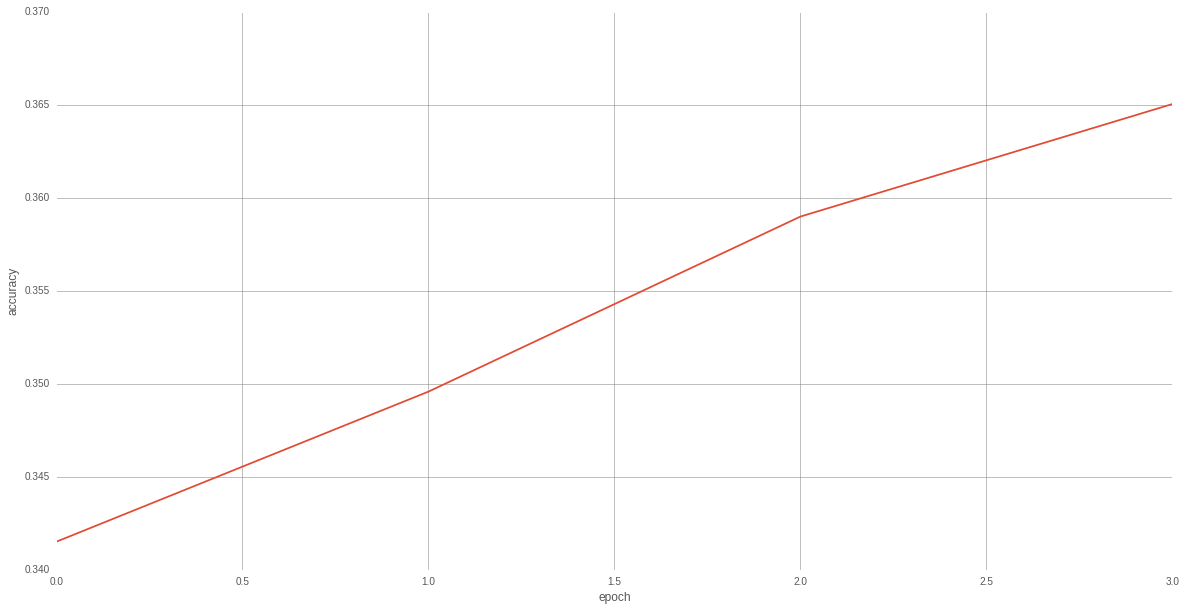

In [49]:
# here is a visualization of the training process
# typically we gain a lot in the beginning and then
# training slows down
plt.plot(model_basic.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")



In [51]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 31.45%


In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 222, 222)      896       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 222, 222)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 111, 111)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 109, 109)      9248      
_________________________________________________________________
activation_16 (Activation)   (None, 32, 109, 109)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 54, 54)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 52, 52)        18496     
__________

In [53]:
model.count_params()

9547374

In [ ]:
#model.save('my_base_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

We only have 4000 posters; that is really small compared to our model parameters 9,547,374. To overcome this issue, we decided to generate more poster images from the poster we already have.

### <span style="color:#08088A"> Deep Learning - Baseline model with data augmentation</span> 

We generate new posters for training from the existing posters, by slightly:

- Translating of poster image
- Rotating of poster image
- Shearing the poster image
- Zooming in/out of the poster image

The poster images generated will be used on real-time data augmentation batches and not save on hard drive.

In [57]:

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

# compute quantities required for featurewise normalization
datagen.fit(X_train)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train)/15,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    callbacks=[lr, early_stopping,
                               ModelCheckpoint('my_augmented_model.h5',save_best_only=True)])


# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/100
198/198 [==============================] - 634s - loss: 2.0142 - acc: 0.3185 - val_loss: 2.2108 - val_acc: 0.2824

Accuracy: 27.84%


What we did to improve our model:

- We tried deeper and shallower networks, playing with the number of layer and the size of the layer
- We added a BatchNormalization layer to the network
- We tried different learning rates (0.1 up to 0.1 / 200) and schedules (cf. to the "Learning rate scheduler" feature)
- We tried different weight initializations and selected the "he_normal" 

Things which can be tried to improve the model:

- We would like to make an ensemble of models
- More data augmentation


# Traditional method: Fine tuning

- Download the weights files for the pre-trained network(s) here VGG19.
- Apply the pre-trained ImageNet networks to your own images.